In [1]:
import requests
import json
import ipywidgets as widgets
import base64
import os
from dotenv import load_dotenv

load_dotenv()
bria_api_token = os.environ.get("BRIA_API_KEY", "Not Found")
bria_api_url = "https://engine.prod.bria-api.com/v1/background/remove"

In [4]:
from jupyter_compare_view import compare
from IPython.display import display
from PIL import Image
from io import BytesIO

target_width = 1000

def prepare_img_url(url):
    return f"{url}?q=60&w={target_width}&auto=format&fit=crop"

def fetch_img(url):
    """Fetches an image from a URL and returns a PIL Image object."""
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses (4xx and 5xx)
        return Image.open(BytesIO(response.content)).convert("RGBA")  # Ensure RGBA mode
    except requests.RequestException as e:
        print(f"Error fetching image from {url}: {e}")
        return None

def convert_to_rgb(image):
    if image.mode == "RGBA":
        rgb_image = Image.new("RGB", image.size, (255, 255, 255))  # Create a new RGB image with a white background
        rgb_image.paste(image, mask=image.split()[3])  # Apply transparency mask
        return rgb_image
    return image  # If already RGB, return as is


def remove_background(image_url):
    """Sends an image URL to the Bria background removal API and returns the processed image."""
    try:
        headers = {"api_token": bria_api_token}
        data = {"image_url": image_url}
        
        response = requests.post(bria_api_url, headers=headers, data=data)
        response.raise_for_status()

        # Extract the result URL from the response
        result_data = response.json()
        result_url = result_data.get("result_url")

        if not result_url:
            print("Error: No result URL returned from API.")
            return None

        return fetch_img(result_url)
    
    except requests.RequestException as e:
        print(f"Error during background removal: {e}")
        return None

def load_image(_url):
    url = prepare_img_url(_url)
    before = fetch_img(url)
    after = remove_background(url)
    
    before = convert_to_rgb(before)
    after = convert_to_rgb(after)

    return (before,after)


before,after = load_image("https://images.unsplash.com/photo-1741334632363-58022899ce91")
# Create the comparison view
compare_widget = compare(before, after, start_mode="horizontal", start_slider_pos=0.5, add_controls=False)


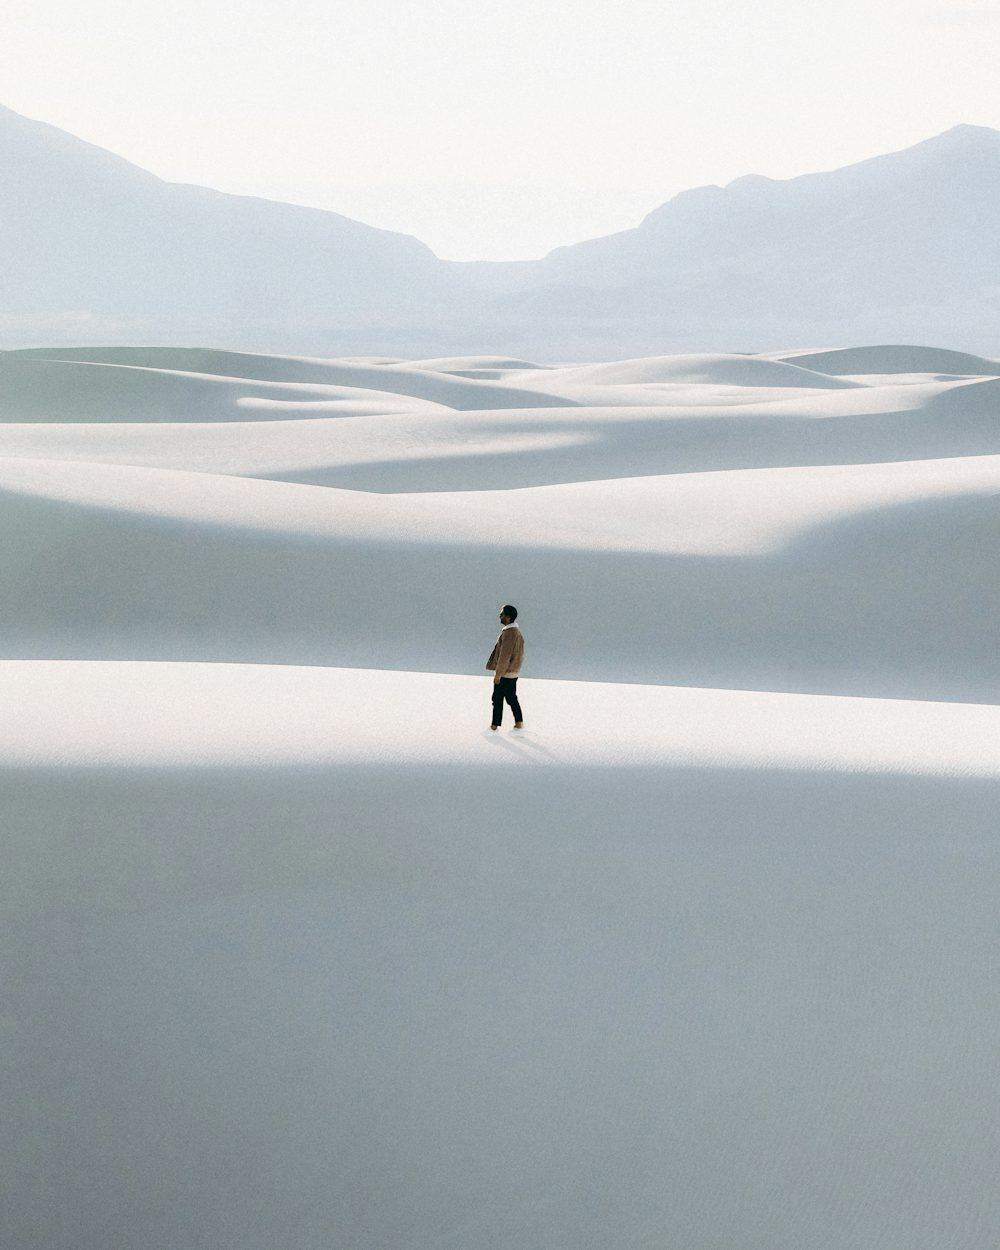
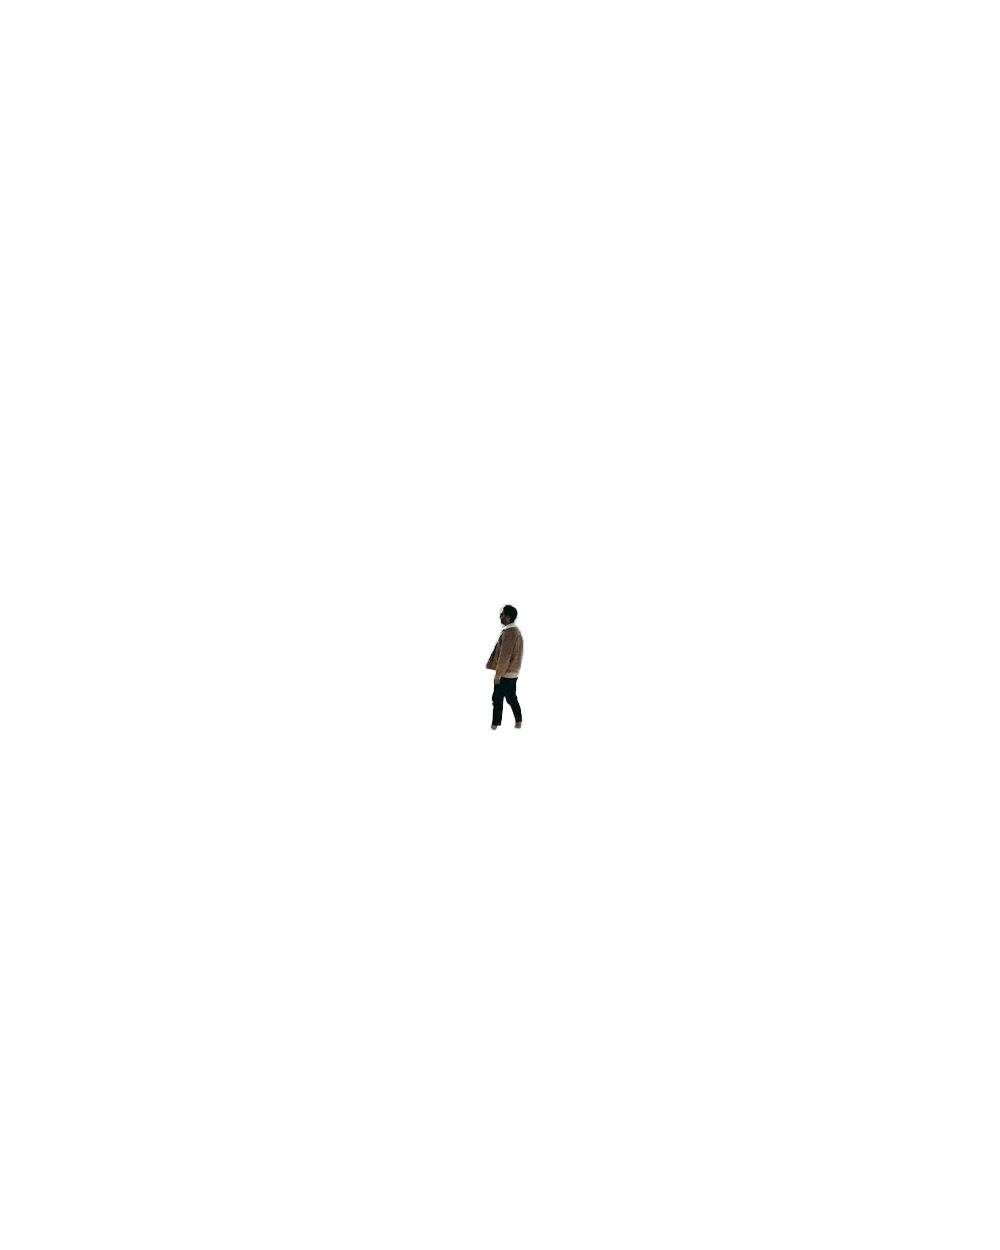

In [5]:
from IPython.core.display import HTML

# Create an HTML wrapper with a border
bordered_widget = f"""
<div style="border: 1px solid black; padding: 10px; display: inline-block;">
    {compare_widget._repr_html_()}
</div>
"""

# Display the bordered widget
display(HTML(bordered_widget))